# Markov Music

Robbie Dozier
Abhi Devathi

In [2]:
# Import all necessary packages
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML
import pgmpy as pgm
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE
import useful
from pygame import mixer
import os
os.chdir('..')
import midivectors

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams['figure.dpi'] = 50

## Summary

In this project, we try to learn the structure of Bach Chorales and then generate music using this structure using probabilistic graphical models. 

## Dataset
The dataset we are using is found at [this link](https://archive.ics.uci.edu/ml/datasets/Bach+Choral+Harmony). It is a .csv file of Bach Chorales with harmonies. Each row of the data represents a different chord (events) in a specific chorale. The dataset contains all the chords from 60 chorales. The features are

    1. Choral ID: corresponding to the file names from [Bach Central](http://www.bachcentral.com)
    2. Event Number
    3-14. Pitch Classes, as a binary variable. 3 is C (YES/NO), 4 is C# (YES/NO),...14 is B (YES/NO)
    15. Bass Note. A character that represents which pitch is the bass note of the chord.
    16. Meter: An integer (1-5) that represents which type of note the chord is. 1 is a whole note, 2 is half note, 3 is a quarter note, 4 is an eighth note and 5 is a sixteenth note.
    17. Chord Label: denotes the name of the chord that is played in the event

### Pre-Processing
First, we parse the data into a form that is friendly for machine learning. We get a dataset that has the same number of events but each vector is now 384 dimensions.

We are only looking at the harmonic content of the data, so everything except for the name of the Chorale and features 3-14 are thrown out. We can then arrange this into a series of $m$-dimensional vectors where $m$ is the number of notes (12 in this case):
$$
\begin{bmatrix}1\\0\\0\\0\\1\\0\\0\\1\\0\\0\\0\\1\end{bmatrix}
$$
<img src="cmaj7.png" alt="Drawing" style="width: 200px;"/>
Next, we take the vectors and arrange them into $m \times n$ matrices, where $n$ is the number of subdivisions (timesteps, in this case, 16th notes.)

Robbie wrote a simple library for doing this processing, and converting the data to MIDI and back. Next, we split the chorales into 32-subdivision (2 measure) segments, then make versions for all 12 keys. Finally, we take the matrix and stack it as a 384-dimensional vector.

The pre-processing functions are found in `midi_vectors`, and the parsing is done in the file `chorales_parse.py`.

The final dataset is saved in the file `data/chorales_vectors_12_32.npy`.

## Dimensionality Reduction

In this section, we employ some dimensionality reduction techniques to show how the space looks.

### Principal Component Analysis

The first technique we employ is PCA because it is simple, and can provide a good baseline for other dimensionality reduction techniques. Further, it allows us to employ an inverse transform from the reduced space to the original space because it is a linear projection. If we suspect that the high-dimensional data lay in a non-linear manifold, we will employ some non-linear methods.

First, we load the data.

In [4]:
data = np.load('data/chorales_vectors_12_32.npy')
data.shape

(1764, 384)

We choose to take, say, 100 components using pca. 

In [16]:
pca = PCA(n_components=100)
data_pca = pca.fit_transform(data)
data_pca.shape

(1764, 100)

Here, we plot the first 3 principal components in a 3-Dimensional plot.

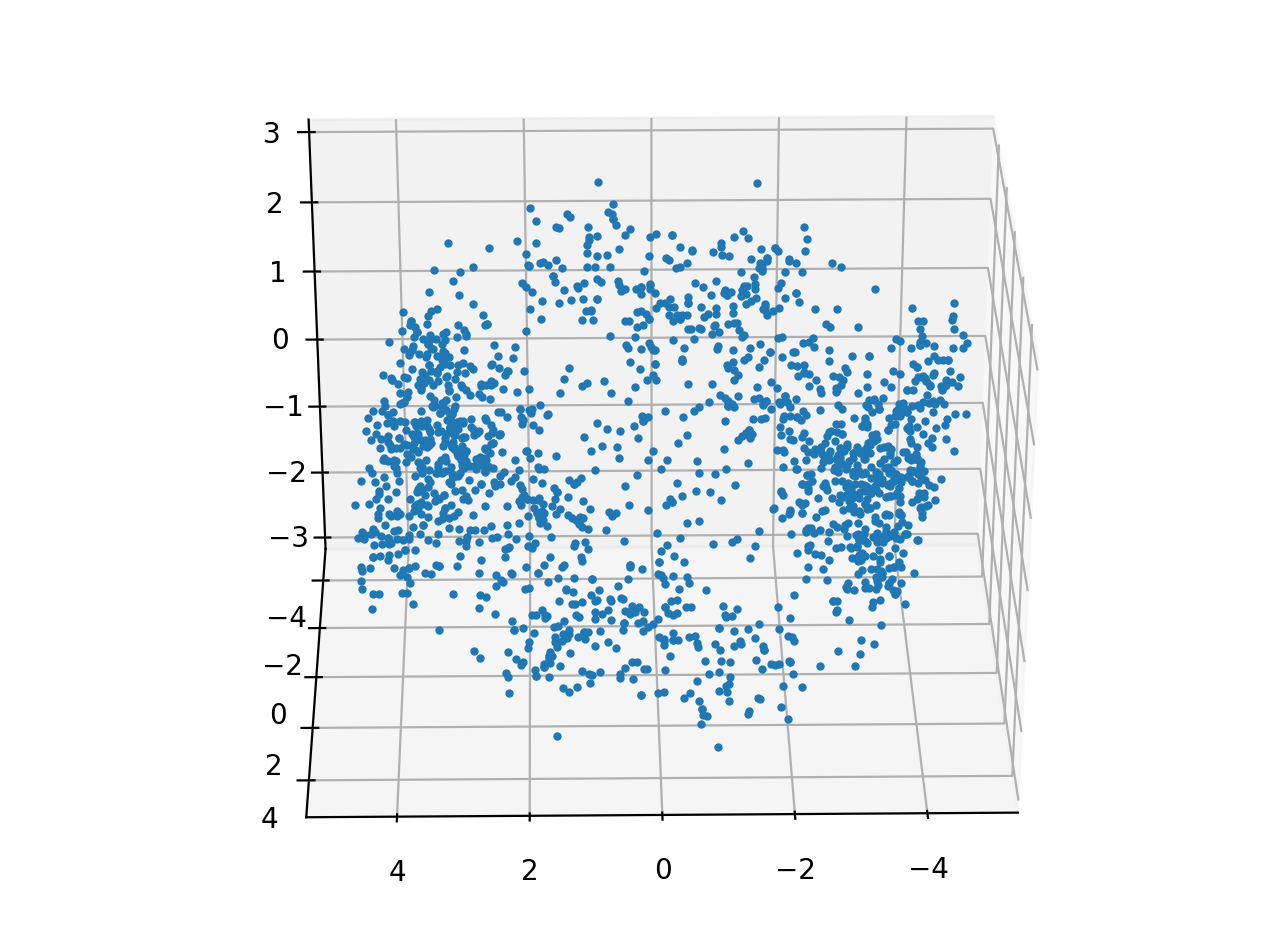

In [17]:
import useful

useful.anim_scatter_3d(
    data_pca[:, :3].T, 
    rcParams=matplotlib.rcParams)

As you can see, there is some clear cylindrical structure that the PCA is capturing.

In [74]:
# Take random data point (sound on)
np.random.seed(1234)
i = np.random.randint(data.shape[0])
point = data[i, :]
m = midivectors.stacked_vector_to_matrix(point, octaves=1)
midivectors.matrix_to_midi(m, 4, bpm=60, hold_notes=True).save('Original_Song.mid')
mixer.init()
mixer.music.load('Original_Song.mid')
mixer.music.play()

In [35]:
# Attempt to take that data point, transform it to PCA, then back
pca_space = data_pca[i, :]

data_space = pca.inverse_transform(pca_space)
data_space = np.where(data_space > .5, 1, 0)

m_tr = midivectors.stacked_vector_to_matrix(data_space, octaves=1)
np.sum(np.abs(data_space - data[1000]))
print("Difference from original data:", np.sum(np.abs(data_space - data[i])))

Difference from original data: 22


In [36]:
# Listen
midivectors.matrix_to_midi(m_tr, 4, bpm=60, hold_notes=True).save('Transformed_Song.mid')
mixer.init()
mixer.music.load('Transformed_Song.mid')
mixer.music.play()

As you might be able to hear, the composition sounds extremely similar using only 100 principal components. The question then becomes, how many components do we actually need to produce solid results? First, let's take a look at the cumulative variance of the principal components.

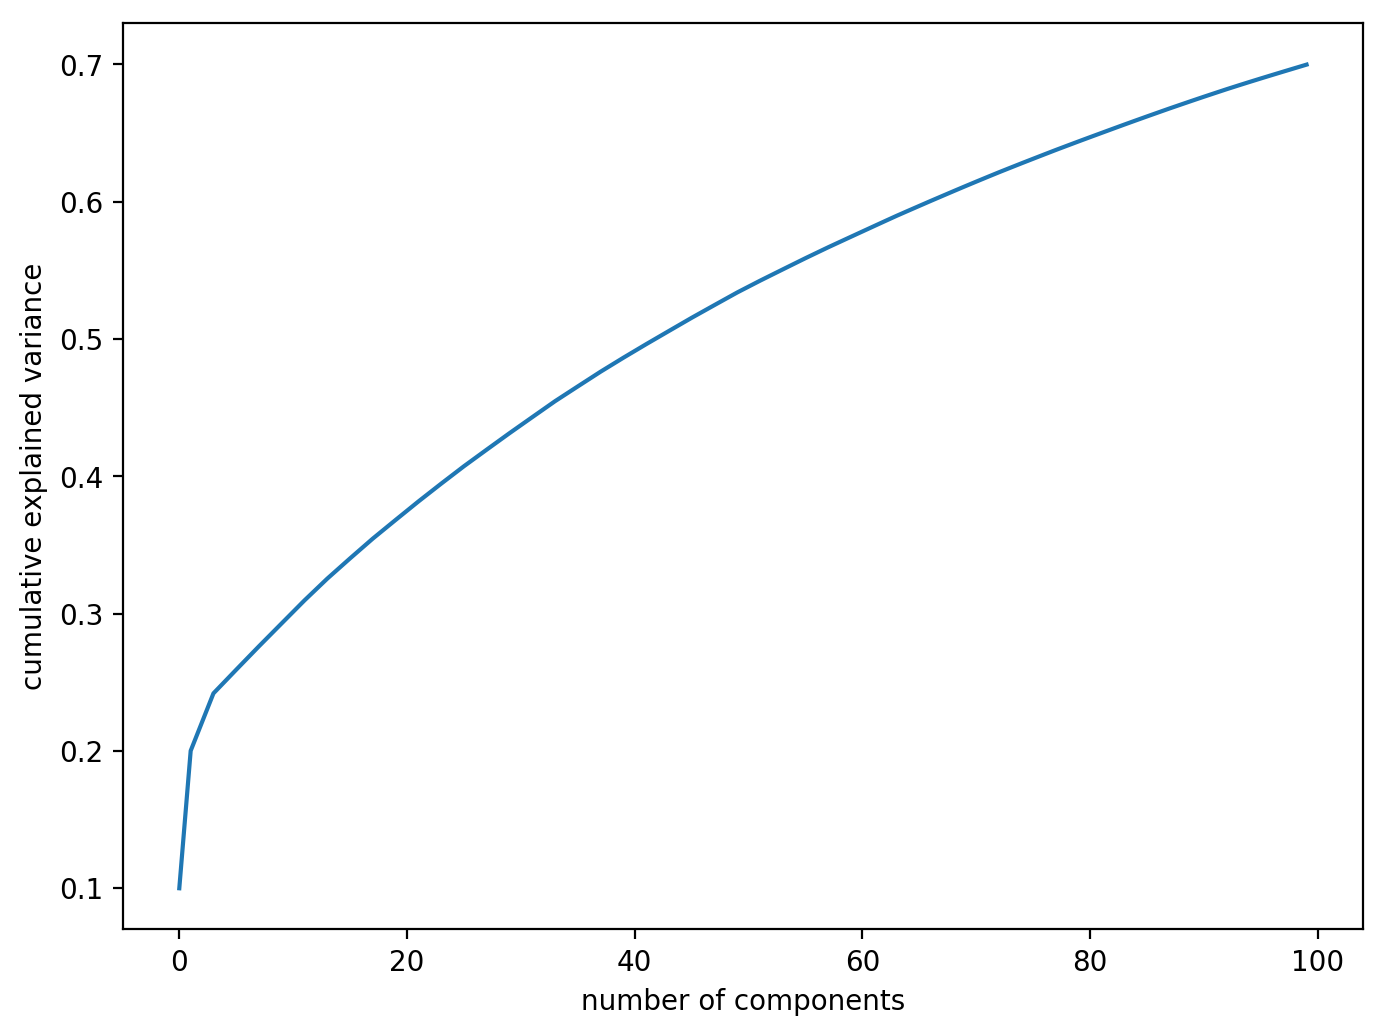

In [37]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

So, it seems like to get 70% explained variance, we need the 100 components. But instead of using this metric, let's see the differences between the inverse transform and the original song for varying number of components.

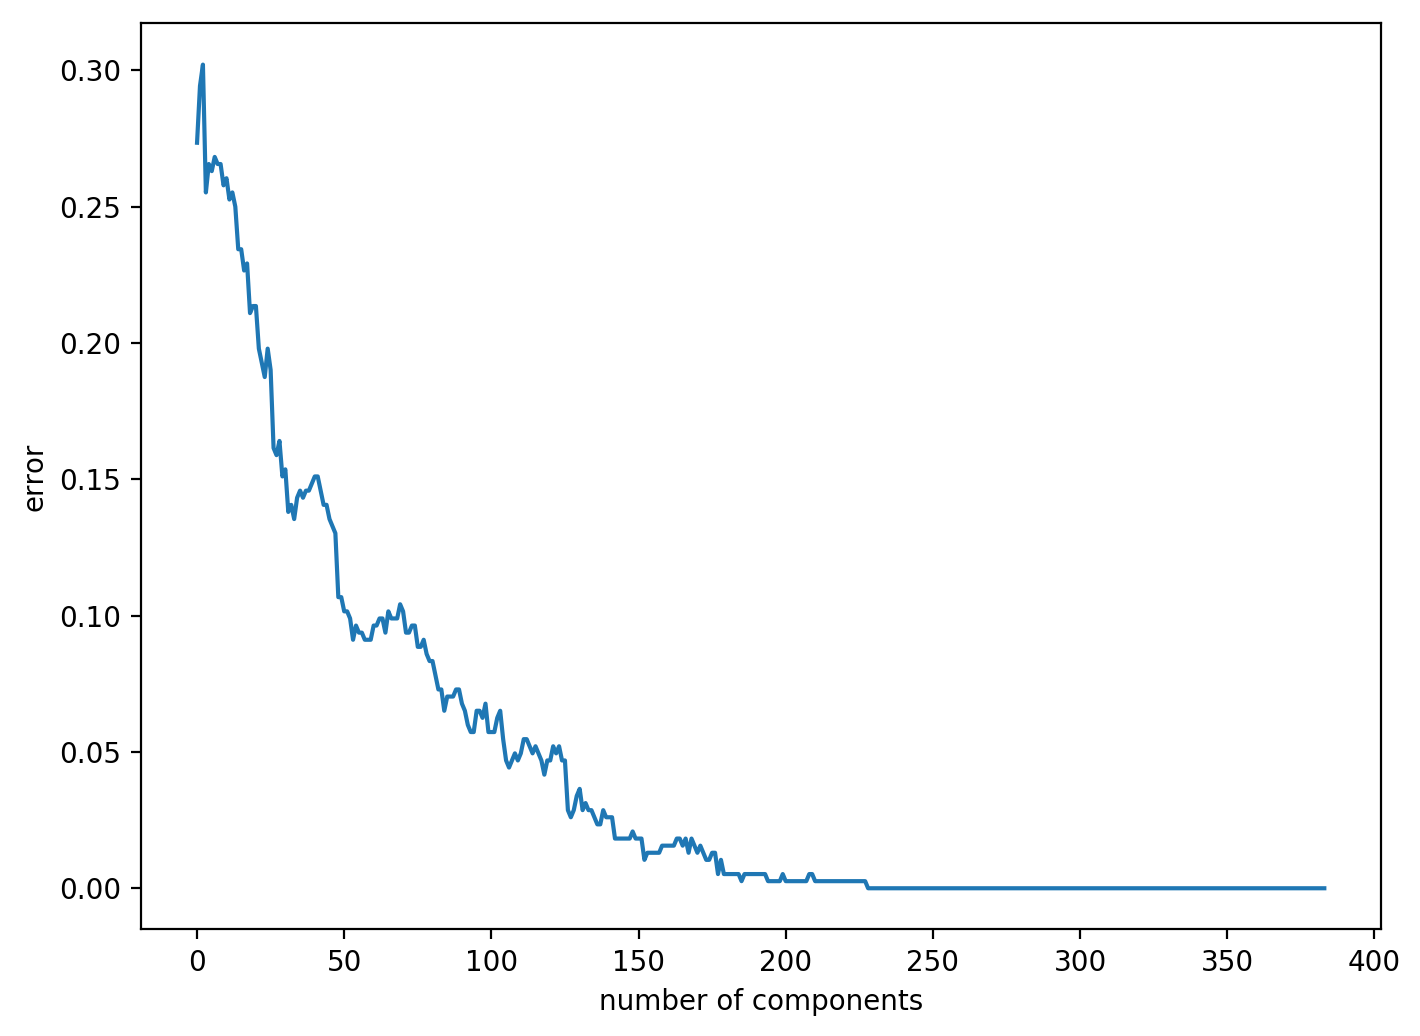

In [60]:
# Find the error for song i given different numbers of principal components.
num_comps_to_check = data.shape[1]
errors = np.empty(num_comps_to_check)
mu = np.mean(data, axis=0)

for nComp in range(num_comps_to_check):
    
    data_trunc = np.dot(pca.transform(data)[:,:nComp], pca.components_[:nComp,:])
    data_trunc += mu
    data_trunc = np.where(data_trunc > .5, 1, 0)
    # print(data_trunc.shape)
    # m_tr = midivectors.stacked_vector_to_matrix(data_trunc, octaves=1)
    errors[nComp] = np.sum(np.abs(data_trunc[i] - data[i]))
#print("Difference from original data:", np.sum(np.abs(data_space - data[1000])))
plt.plot(errors)
plt.xlabel('number of components')
plt.ylabel('error');
plt.show()

So, to get an exact reconstruction, we only need to take about 230 components, a little more than half the total. This is pretty good, however we don't even need a perfect reconstruction to get a viable estimate. You can mess around with the number of components to see how the inverse transformed data sounds at each stage.

In reality, the curve should not be jagged like this as increasing the number of components should always decrease the error with the true point. However, since we have to round to ensure all points or 0 or 1, this produces some roundoff errors which you can see in the jaggedness.

In [81]:
# Sound on
nComp = 150 # Number of components

data_trunc = np.dot(pca.transform(data)[:,:nComp], pca.components_[:nComp,:])
data_trunc += mu
data_trunc = np.where(data_trunc > .5, 1, 0)
this_truncation = 'data/Truncated_Song.mid'
# print(data_trunc.shape)
midi_trunc = midivectors.stacked_vector_to_matrix(data_trunc[i], octaves=1)
midivectors.matrix_to_midi(midi_trunc, 4, bpm=60, hold_notes=True).save(this_truncation)
mixer.init()
mixer.music.load(this_truncation)
mixer.music.play()